In [2]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.fftpack import dct

data_dir = "/Akamai/voice/data/Scherbaum Mshavanadze/GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919/"
pitch_dir = 'Akamai/voice/data/pitches/'

y, sr = librosa.load(data_dir + "GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919_ALRX3M.mp3")

min_period = np.int(sr/500)
max_period = np.int(sr/50)
N = np.int(3/min_period * sr)

def load_file (name):
    y, sr = librosa.load(data_dir+name)
    return (y, sr)

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


In [3]:
def preprocessing (signal, start_time, window_size):
    hamming = np.hamming(window_size)
    hamming = hamming ** 2
    e_sum = np.sum(hamming)
    hamming = hamming/e_sum
    hamming = np.sqrt(hamming)
    
    signal[start_time:start_time+window_size] = hamming * signal[start_time:start_time+window_size]
    return signal

## Periodicity Measure

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


1.3145467242298037e-08
0.009450023017432231


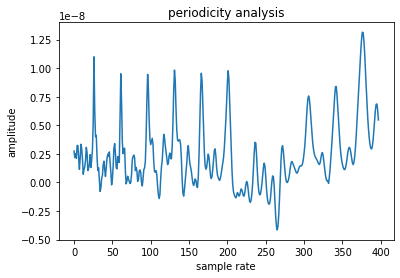

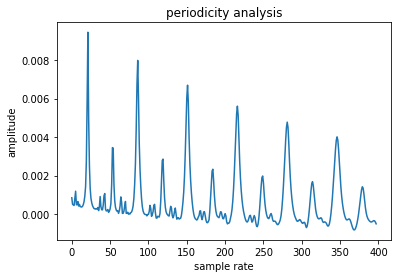

In [4]:
def find_periodicity_max (n_o, graph=False):
    global y, sr, N
    
    processed = preprocessing(np.copy(y), n_o, 2*N+1)

    def autocorrelation (l):                
        f = processed[n_o:N-abs(l)+n_o]
        s = processed[abs(l)+n_o:N+n_o]
        return (1/N) * np.sum(np.multiply(f, s))

    def vlamdf (l):        
        f = processed[n_o+l:n_o+2*l]
        s = processed[n_o:l+n_o]
        numerator = np.sum(np.abs(np.subtract(f, s)))
        f = processed[n_o:2*l-1+n_o]
        denominator = 0.5 * np.sum(np.abs(f))
        return numerator/denominator

    def enhanced_acf (p_l, N_max, arg_max):
        return N_max * ((N-1)/(N-arg_max)) - p_l
    
    vect_autocorrelation = np.vectorize(autocorrelation)
    vect_vlamdf = np.vectorize(vlamdf)

    epsilon = 1
    correlation = vect_autocorrelation(np.arange(N))
    p_l = np.nan_to_num(vect_vlamdf(np.arange(N)))
    n_l = np.divide(correlation, p_l + epsilon)
    
    k_l = enhanced_acf(p_l, np.max(p_l), np.argmax(p_l))
    j_l = np.multiply(n_l, k_l)
    
    def sphf (tau):
        y = np.arange(1, np.int(N/tau)) * tau
        return np.sum(j_l[y]) * tau
    
    vect_sphf = np.vectorize(sphf)
    
    p_t = vect_sphf(np.arange(min_period, max_period+1))
    cy = np.max(p_t)
    
    if graph:
        plt.figure()
        plt.plot(p_t)
        plt.xlabel('sample rate')
        plt.ylabel('amplitude')
        plt.title('periodicity analysis')
    
    return cy

sr = 22050
print(find_periodicity_max(1 * sr, graph=True)) # unvoiced
print(find_periodicity_max(21 * sr, graph=True)) # voiced

## Zero-crossing rate-weighted RMS energy

In [5]:
def sgn (x):
    if x == 0:
        return 0
    elif x > 0:
        return 1
    else:
        return -1

def find_weighted_zero_crossing (n_o):
    processed = preprocessing(np.copy(y), n_o, N+1)
    rms = np.sqrt(np.sum(processed[n_o+1:n_o+N+1] ** 2) / N)
    
    vect_sgn = np.vectorize(sgn)
    zcr = np.sum(np.abs(np.subtract(vect_sgn(processed[n_o+1:n_o+N]), vect_sgn(processed[n_o:n_o+N-1]))))
    
    return rms/zcr
    
sr = 22050
print(find_weighted_zero_crossing(1 * sr)) # unvoiced
print(find_weighted_zero_crossing(20 * sr)) # voiced

1.6849150580328772e-07
7.185103918084809e-05


## Kaiser-Teager frame energy

In [6]:
def kaiser_teager (l, r, m):
    return m**2 - np.multiply(l, r)

def find_kaiser_teager_frame_energy (n_o):
    processed = preprocessing(np.copy(y), n_o, N+1)
    n = processed[np.arange(n_o-1, n_o + N+1)]    
    k_t = kaiser_teager(n[:-2], n[2:], n[1:-1])
    return np.sqrt(np.sum(k_t))

sr = 22050
print(find_kaiser_teager_frame_energy(0 * sr)) # unvoiced
print(find_kaiser_teager_frame_energy(20 * sr)) # voiced

0.00010496664
0.09997276


## Normalized low-frequency energy ratio

In [7]:
from scipy import signal
from scipy.fft import fftshift

spectogram = None

def generate_spectogram():
    global spectogram
    f, t, Sxx = signal.spectrogram(np.copy(y), sr, nperseg=N, noverlap=N-220)
    spectogram = Sxx
    
def find_low_frequency_energy_ratio (n_o):
    n_o = int(round((n_o)/220))
    total_sum = np.sum(spectogram) / N
    return np.sum(spectogram[:, n_o]) / total_sum

sr = 22050
generate_spectogram()
print(find_low_frequency_energy_ratio(1 * sr)) # unvoiced
print(find_low_frequency_energy_ratio(20 * sr)) # voiced

4.615970227421261e-06
0.6547052374802326


## Voiced/Unvoiced Classification

The research paper states to first create an unvoiced subset as such:
```python
(features[:, 0] < periodicity_median) & (features[:, 1] \< zero_crossing_median) & (features[:, 2] < kaiser_teager_frame_median) & (features[:, 3] < low_frequency_energy_median)
```

however only using the second subset generated with:
```python
for i in range(low_subset.size):
    c = 0
    if (features[:, 0][i] >= thresholed_periodicity[i]):
        c += 1
    if (i < low_subset.size-1 and features[:, 0][i+1] >= thresholed_periodicity[i+1]):
        c += 1
    if (i > 0 and features[:, 0][i-1] >= thresholed_periodicity[i-1]):
        c += 1
    if (i < low_subset.size-1 and features[:, 0][i+1] < thresholed_periodicity[i+1]):
        c += 1
    if (features[:, 1][i] >= zero_crossing_median):
        c += 1
    if (features[:, 2][i] >= kaiser_teager_frame_median):
        c += 1
    if (features[:, 3][i] >= low_frequency_energy_median):
        c += 1
    
    if (c >= 5):
        second_high_subset[i] = True

```
with the modification of medians to be this:
```python
periodicity_median = np.sort(features[:, 0])[np.int(features.shape[0]/4)]
zero_crossing_median = np.sort(features[:, 1])[np.int(features.shape[0]/4)]
kaiser_teager_frame_median = np.sort(features[:, 2])[np.int(features.shape[0]/4)]
low_frequency_energy_median = np.sort(features[:, 3])[np.int(features.shape[0]/4)]
``` 
provided better results

In [ ]:
def create_and_store (song_names):
    global y, sr, dp
    done = 0
    for song_name in song_names:
        y, sr = load_file(song_name)
        duration = y.size/sr
        frames = np.arange(0, duration, 0.01)
        frames_in_samples = (frames * sr).astype('int')
        min_period = np.int(sr/500)
        max_period = np.int(sr/50)
        N = np.int(3/min_period * sr)
                                    
        song_dir = pitch_dir + song_name
        song_dir = song_dir[:-4] + ".txt"
        
        generate_spectogram()
        features = np.empty(shape=(frames.size, 4))
        for i, frame in enumerate(frames_in_samples[0:-15]):
            features[i][0] = find_periodicity_max(frame)
            features[i][1] = find_weighted_zero_crossing(frame)
            features[i][2] = find_kaiser_teager_frame_energy(frame)
            features[i][3] = find_low_frequency_energy_ratio(frame)
            
            print(f"{round((i+1)/(frames_in_samples.size-15) * 100, 2)}% done", end='\r')
            
        alpha = 0.2
            
        periodicity_median = np.sort(features[:, 0])[np.int(features.shape[0]//2)] * alpha
        zero_crossing_median = np.sort(features[:, 1])[np.int(features.shape[0]//2)] * alpha
        kaiser_teager_frame_median = np.sort(features[:, 2])[np.int(features.shape[0]//2)] * alpha
        low_frequency_energy_median = np.sort(features[:, 3])[np.int(features.shape[0]//2)] * alpha
        
        first_low_subset = (features[:, 0] < periodicity_median) & (features[:, 1] < zero_crossing_median) & (features[:, 2] < kaiser_teager_frame_median) & (features[:, 3] < low_frequency_energy_median)
        first_high_subset = ~first_low_subset
        second_high_subset = np.zeros(features[:, 0].size) == 1
        
        thresholed_periodicity = np.copy(features[:, 0])
        thresholed_periodicity[thresholed_periodicity > periodicity_median] = periodicity_median

        for i in range(features[:, 0].size):
            c = 0
            if (features[:, 0][i] >= thresholed_periodicity[i]):
                c += 1
            if (i < features[:, 0].size-1 and features[:, 0][i+1] >= thresholed_periodicity[i+1]):
                c += 1
            if (i > 0 and features[:, 0][i-1] >= thresholed_periodicity[i-1]):
                c += 1
            if (i < features[:, 0].size-1 and features[:, 0][i+1] < thresholed_periodicity[i+1]):
                c += 1
            if (features[:, 1][i] >= zero_crossing_median):
                c += 1
            if (features[:, 2][i] >= kaiser_teager_frame_median):
                c += 1
            if (features[:, 3][i] >= low_frequency_energy_median):
                c += 1

            if (c >= 5):
                second_high_subset[i] = True

        f = (first_high_subset & second_high_subset).astype('int').tolist()
        for i in range(len(f)):
            f[i] = str(frames[i]) + ' ' + str(f[i])
        
        fout = open(song_dir, "w+")
        fout.write("\n".join(str(x) for x in f))
        fout.close()
        
        done += 1
        print(f"{done} done")
        
data_dir = "/Akamai/voice/data/Scherbaum Mshavanadze/GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919/"
pitch_dir = "/Akamai/voice/data/pitches/v-uv/Scherbaum Mshavanadze/GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919/"
create_and_store([
#     "GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919_ALRX1M.mp3",
    "GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919_AHDS1M.mp3",
    "GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919_AHDS2M.mp3",
    "GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919_AHDS3M.mp3",
#     "GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919_ALRX2M.mp3",
#     "GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919_ALRX3M.mp3",
#     "GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919_AOLS5S.mp3",
#     "GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919_VSOAX4.mp3"
])

data_dir = "/Akamai/voice/data/Scherbaum Mshavanadze/GVM017_ChvenMshvidobaTake2_Ozurgeti_ShalvaChemo2016_20160713/"
pitch_dir = "/Akamai/voice/data/pitches/v-uv/Scherbaum Mshavanadze/GVM017_ChvenMshvidobaTake2_Ozurgeti_ShalvaChemo2016_20160713/"
create_and_store([
    "GVM017_ChvenMshvidobaTake2_Ozurgeti_ShalvaChemo2016_20160713_AHDS1M.mp3",
    "GVM017_ChvenMshvidobaTake2_Ozurgeti_ShalvaChemo2016_20160713_AHDS2M.mp3",
    "GVM017_ChvenMshvidobaTake2_Ozurgeti_ShalvaChemo2016_20160713_AHDS3M.mp3",
#     "GVM017_ChvenMshvidobaTake2_Ozurgeti_ShalvaChemo2016_20160713_ALRX1M.mp3",
#     "GVM017_ChvenMshvidobaTake2_Ozurgeti_ShalvaChemo2016_20160713_ALRX2M.mp3",
#     "GVM017_ChvenMshvidobaTake2_Ozurgeti_ShalvaChemo2016_20160713_ALRX3M.mp3",
#     "GVM017_ChvenMshvidobaTake2_Ozurgeti_ShalvaChemo2016_20160713_AOLS5S.mp3",
#     "GVM017_ChvenMshvidobaTake2_Ozurgeti_ShalvaChemo2016_20160713_VSOAX4.mp3"
])

data_dir = "/Akamai/voice/data/Scherbaum Mshavanadze/GVM019_DaleKojas_DidgoriVillage_Didgori_20160707/"
pitch_dir = "/Akamai/voice/data/pitches/v-uv/Scherbaum Mshavanadze/GVM019_DaleKojas_DidgoriVillage_Didgori_20160707/"
create_and_store([
    "GVM019_DaleKojas_DidgoriVillage_Didgori_20160707_AHDS1M.mp3",
    "GVM019_DaleKojas_DidgoriVillage_Didgori_20160707_AHDS2M.mp3",
    "GVM019_DaleKojas_DidgoriVillage_Didgori_20160707_AHDS3M.mp3",
#     "GVM019_DaleKojas_DidgoriVillage_Didgori_20160707_ALRX1M.mp3",
#     "GVM019_DaleKojas_DidgoriVillage_Didgori_20160707_ALRX2M.mp3",
#     "GVM019_DaleKojas_DidgoriVillage_Didgori_20160707_ALRX3M.mp3",
#     "GVM019_DaleKojas_DidgoriVillage_Didgori_20160707_AOLS5S.mp3",
#     "GVM019_DaleKojas_DidgoriVillage_Didgori_20160707_VSOAX4.mp3"
])

data_dir = "/Akamai/voice/data/Scherbaum Mshavanadze/GVM031_EliaLrde_LakhushdiVillage_MuradGigoGivi_20160819/"
pitch_dir = "/Akamai/voice/data/pitches/v-uv/Scherbaum Mshavanadze/GVM031_EliaLrde_LakhushdiVillage_MuradGigoGivi_20160819/"
create_and_store([
    "GVM031_EliaLrde_LakhushdiVillage_MuradGigoGivi_20160819_AHDS1M.mp3",
    "GVM031_EliaLrde_LakhushdiVillage_MuradGigoGivi_20160819_AHDS2M.mp3",
    "GVM031_EliaLrde_LakhushdiVillage_MuradGigoGivi_20160819_AHDS3M.mp3",
#     "GVM031_EliaLrde_LakhushdiVillage_MuradGigoGivi_20160819_ALRX1M.mp3",
#     "GVM031_EliaLrde_LakhushdiVillage_MuradGigoGivi_20160819_ALRX2M.mp3",
#     "GVM031_EliaLrde_LakhushdiVillage_MuradGigoGivi_20160819_ALRX3M.mp3",
#     "GVM031_EliaLrde_LakhushdiVillage_MuradGigoGivi_20160819_AOLS5S.mp3",
#     "GVM031_EliaLrde_LakhushdiVillage_MuradGigoGivi_20160819_VSOAX4.mp3"
])

data_dir = "/Akamai/voice/data/Scherbaum Mshavanadze/GVM097_KristeAghsdga_LakhushdiVillage_MuradGigoGivi_20160819/"
pitch_dir = "/Akamai/voice/data/pitches/v-uv/Scherbaum Mshavanadze/GVM097_KristeAghsdga_LakhushdiVillage_MuradGigoGivi_20160819/"
create_and_store([
    "GVM097_KristeAghsdga_LakhushdiVillage_MuradGigoGivi_20160819_AHDS1M.mp3",
    "GVM097_KristeAghsdga_LakhushdiVillage_MuradGigoGivi_20160819_AHDS2M.mp3",
    "GVM097_KristeAghsdga_LakhushdiVillage_MuradGigoGivi_20160819_AHDS3M.mp3",
#     "GVM097_KristeAghsdga_LakhushdiVillage_MuradGigoGivi_20160819_ALRX1M.mp3",
#     "GVM097_KristeAghsdga_LakhushdiVillage_MuradGigoGivi_20160819_ALRX2M.mp3",
#     "GVM097_KristeAghsdga_LakhushdiVillage_MuradGigoGivi_20160819_ALRX3M.mp3",
#     "GVM097_KristeAghsdga_LakhushdiVillage_MuradGigoGivi_20160819_AOLS5S.mp3",
#     "GVM097_KristeAghsdga_LakhushdiVillage_MuradGigoGivi_20160819_VSOAX4.mp3"
])

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


1 done done


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


2 done done


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


3 done done


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


1 done done


/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


### Comparison with Praat

In [ ]:
def separate(adir, algo):
    if algo=='praat':
        a = list(map(lambda x: x.strip().split(" "), open(adir).readlines()))    
        x = [0 for i in range(len(a))]
        y = [0 for i in range(len(a))]

        for i in range(len(a)):
                if a[i][3] == '--undefined--':
                    x[i] = float(a[i][0])-0.07
                    y[i] = 0
                else:
                    x[i] = float(a[i][0])-0.07
                    y[i] = float(a[i][3])
        return (x,y)
    else:
        conv={}
        if algo=='yin':
            conv[0] = lambda s: float(s.strip() or 0)-0.025
        x,y = np.loadtxt(adir, unpack=True, converters=conv)
        return (x,y)

In [ ]:
data_dir = "/Akamai/voice/data/pitches/praat/Scherbaum Mshavanadze/GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919/GVM009_BatonebisNanina_Tbilisi_Mzetamze_20160919_ALRX1M.txt"
praat_x, praat_y = separate(data_dir, "praat")
praat_y = np.array(praat_y)
praat_v = praat_y > 0

plt.figure(figsize=(20, 5))
plt.plot(frames, final_decision[:frames.size], '.', label="algo")
plt.plot(praat_x, praat_v[:praat_v.size], '.', label="actual")
plt.legend()

print(frames)